# Задача "Титаник"

In [1]:
import pandas as pd
import scipy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math as m
import sklearn
import re

In [2]:
# Соединим тренировочную и тестовыю выборки в одну для модификации данных.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_size = train.shape[0]
all_data = pd.concat([train, test])
all_data = all_data.reset_index(drop=True)
all_data.head(535)

PassengerId  Survived  Pclass  \
0            486       0.0       3   
1            426       0.0       3   
2            780       1.0       1   
3            248       1.0       2   
4            184       1.0       2   
..           ...       ...     ...   
530          375       0.0       3   
531          177       0.0       3   
532          438       1.0       2   
533          461       1.0       1   
534          384       NaN       1   

                                                  Name     Sex   Age  SibSp  \
0                               Lefebre, Miss. Jeannie  female   NaN      3   
1                               Wiseman, Mr. Phillippe    male   NaN      0   
2    Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  female  43.0      0   
3                      Hamalainen, Mrs. William (Anna)  female  24.0      0   
4                            Becker, Master. Richard F    male   1.0      2   
..                                                 ...     ...   ...    ...   
530                         Palsson, Miss. Stina Viola  female   3.0      3   
531                      Lefebre, Master. Henry Forbes    male   NaN      3   
532              Richards, Mrs. Sidney (Emily Hocking)  female  24.0      2   
533                                Anderson, Mr. Harry    male  48.0      0   
534  Holverson, Mrs. Alexander Oskar (Mary Aline To...  female  35.0      1   

     Parch      Ticket      Fare Cabin Embarked  
0        1        4133   25.4667   NaN        S  
1        0  A/4. 34244    7.2500   NaN        S  
2        1       24160  211.3375    B3        S  
3        2      250649   14.5000   NaN        S  
4        1      230136   39.0000    F4        S  
..     ...         ...       ...   ...      ...  
530      1      349909   21.0750   NaN        S  
531      1        4133   25.4667   NaN        S  
532      3       29106   18.7500   NaN        S  
533      0       19952   26.5500   E12        S  
534      0      113789   52.0000   NaN        S  

[535 rows x 12 columns]

In [3]:
# Узнаем кол-во пропусков (NaN-ов) 
all_data.isna().sum()

PassengerId      0
Survived       357
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     534 non-null    float64
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 83.7+ KB


### Проверим числовые параметры на выбросы 

In [5]:
## Функция для построения гистограммы
def hystogramma(v, name):
    fig, ax = plt.subplots()
    sns.histplot(v, kde=True, ax=ax, bins=15)
    plt.xlabel(name, size=15)
    plt.ylabel("frequency", size=15)
    plt.show()

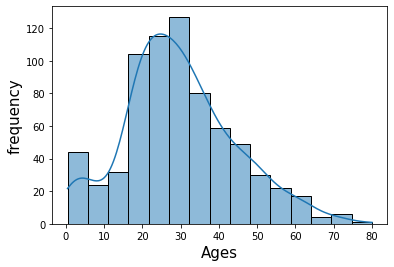

In [6]:
hystogramma(all_data["Age"], "Ages")

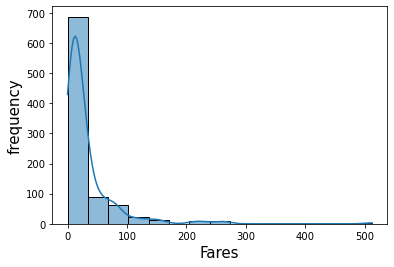

In [7]:
hystogramma(all_data['Fare'], "Fares")

In [8]:
# Выбросов не обнаружено, заполним пропуски в возрасте

### Заполним пропуски на медиану взависимости от пола

In [9]:
ages = all_data.groupby('Sex')['Age'].median()
all_data["Age"] = all_data.apply( lambda x: ages[x['Sex']] if pd.isnull(x['Age']) else x['Age'], axis = 1)   
print(ages)

Sex
female    27.0
male      29.0
Name: Age, dtype: float64


In [10]:
all_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
all_data["Sex"] = all_data["Sex"].astype('category')

In [12]:
all_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     534 non-null    float64 
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
dtypes: category(1), float64(3), int64(4), object(4)
memory usage: 77.7+ KB


In [14]:
# Удаляем не информативные слобцы
all_data = all_data.drop(['PassengerId'], 1)

In [15]:
all_data["Relatives"] = all_data["Parch"] + all_data["SibSp"]
all_data["Single"] = all_data["Relatives"].apply(lambda r: 1 if r == 0 else 0)
all_data = all_data.drop(['SibSp'], 1)
all_data = all_data.drop(['Parch'], 1)

In [16]:
# Удалим пропуски из колонки Embarked
all_data["Embarked"] = all_data["Embarked"].astype('category')
#all_data = all_data.dropna(subset=['Embarked']).reset_index(drop=True)
#all_data["Embarked"] = all_data.apply( lambda x: mode if pd.isnull(x['Embarked']) else x['Embarked'], axis = 1)
all_data["Embarked"] = all_data["Embarked"].replace({np.nan: "S"})
all_data.isna().sum()

Survived     357
Pclass         0
Name           0
Sex            0
Age            0
Ticket         0
Fare           0
Cabin        687
Embarked       0
Relatives      0
Single         0
dtype: int64

In [17]:
from sklearn.preprocessing import OneHotEncoder

def one_hot(df, col):
    enc = OneHotEncoder()
    enc_df = pd.DataFrame(enc.fit_transform(df[[col]]).toarray())
    enc_df = enc_df.astype('int')
    df = df.join(enc_df)
    return df

def binar_one_hot(df, col):
    df = df.copy()
    enc = OneHotEncoder(drop="if_binary")
    enc_df = pd.DataFrame(enc.fit_transform(df[[col]]).toarray())
    enc_df = enc_df.astype('int')
    df = df.join(enc_df)
    return df

In [18]:
all_data

Survived  Pclass                                               Name  \
0         0.0       3                             Lefebre, Miss. Jeannie   
1         0.0       3                             Wiseman, Mr. Phillippe   
2         1.0       1  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...   
3         1.0       2                    Hamalainen, Mrs. William (Anna)   
4         1.0       2                          Becker, Master. Richard F   
..        ...     ...                                                ...   
886       NaN       3                              Attalah, Miss. Malake   
887       NaN       3                           Risien, Mr. Samuel Beard   
888       NaN       2                          Hickman, Mr. Leonard Mark   
889       NaN       3                    Sandstrom, Miss. Marguerite Rut   
890       NaN       1  Penasco y Castellana, Mrs. Victor de Satode (M...   

        Sex   Age        Ticket      Fare Cabin Embarked  Relatives  Single  
0    female  27.0          4133   25.4667   NaN        S          4       0  
1      male  29.0    A/4. 34244    7.2500   NaN        S          0       1  
2    female  43.0         24160  211.3375    B3        S          1       0  
3    female  24.0        250649   14.5000   NaN        S          2       0  
4      male   1.0        230136   39.0000    F4        S          3       0  
..      ...   ...           ...       ...   ...      ...        ...     ...  
886  female  17.0          2627   14.4583   NaN        C          0       1  
887    male  29.0        364498   14.5000   NaN        S          0       1  
888    male  24.0  S.O.C. 14879   73.5000   NaN        S          2       0  
889  female   4.0       PP 9549   16.7000    G6        S          2       0  
890  female  17.0      PC 17758  108.9000   C65        C          1       0  

[891 rows x 11 columns]

In [19]:
binar_one_hot(all_data, 'Sex')

Survived  Pclass                                               Name  \
0         0.0       3                             Lefebre, Miss. Jeannie   
1         0.0       3                             Wiseman, Mr. Phillippe   
2         1.0       1  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...   
3         1.0       2                    Hamalainen, Mrs. William (Anna)   
4         1.0       2                          Becker, Master. Richard F   
..        ...     ...                                                ...   
886       NaN       3                              Attalah, Miss. Malake   
887       NaN       3                           Risien, Mr. Samuel Beard   
888       NaN       2                          Hickman, Mr. Leonard Mark   
889       NaN       3                    Sandstrom, Miss. Marguerite Rut   
890       NaN       1  Penasco y Castellana, Mrs. Victor de Satode (M...   

        Sex   Age        Ticket      Fare Cabin Embarked  Relatives  Single  0  
0    female  27.0          4133   25.4667   NaN        S          4       0  0  
1      male  29.0    A/4. 34244    7.2500   NaN        S          0       1  1  
2    female  43.0         24160  211.3375    B3        S          1       0  0  
3    female  24.0        250649   14.5000   NaN        S          2       0  0  
4      male   1.0        230136   39.0000    F4        S          3       0  1  
..      ...   ...           ...       ...   ...      ...        ...     ... ..  
886  female  17.0          2627   14.4583   NaN        C          0       1  0  
887    male  29.0        364498   14.5000   NaN        S          0       1  1  
888    male  24.0  S.O.C. 14879   73.5000   NaN        S          2       0  1  
889  female   4.0       PP 9549   16.7000    G6        S          2       0  0  
890  female  17.0      PC 17758  108.9000   C65        C          1       0  0  

[891 rows x 12 columns]

In [20]:
all_data = binar_one_hot(all_data, 'Sex')
all_data = all_data.drop(['Sex'], 1)
all_data = all_data.rename({0: 'Sex'}, axis=1)
all_data.head()

Survived  Pclass                                               Name   Age  \
0       0.0       3                             Lefebre, Miss. Jeannie  27.0   
1       0.0       3                             Wiseman, Mr. Phillippe  29.0   
2       1.0       1  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  43.0   
3       1.0       2                    Hamalainen, Mrs. William (Anna)  24.0   
4       1.0       2                          Becker, Master. Richard F   1.0   

       Ticket      Fare Cabin Embarked  Relatives  Single  Sex  
0        4133   25.4667   NaN        S          4       0    0  
1  A/4. 34244    7.2500   NaN        S          0       1    1  
2       24160  211.3375    B3        S          1       0    0  
3      250649   14.5000   NaN        S          2       0    0  
4      230136   39.0000    F4        S          3       0    1

In [21]:
all_data = one_hot(all_data, 'Embarked')
all_data = all_data.rename({0: 'C', 1: 'Q', 2: 'S'}, axis = 1)
all_data = all_data.drop(['Embarked'], 1)
all_data.head()

Survived  Pclass                                               Name   Age  \
0       0.0       3                             Lefebre, Miss. Jeannie  27.0   
1       0.0       3                             Wiseman, Mr. Phillippe  29.0   
2       1.0       1  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  43.0   
3       1.0       2                    Hamalainen, Mrs. William (Anna)  24.0   
4       1.0       2                          Becker, Master. Richard F   1.0   

       Ticket      Fare Cabin  Relatives  Single  Sex  C  Q  S  
0        4133   25.4667   NaN          4       0    0  0  0  1  
1  A/4. 34244    7.2500   NaN          0       1    1  0  0  1  
2       24160  211.3375    B3          1       0    0  0  0  1  
3      250649   14.5000   NaN          2       0    0  0  0  1  
4      230136   39.0000    F4          3       0    1  0  0  1

In [22]:
def get_title(name):
    if pd.isnull(name):
        return "Null"
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1).lower()
    else:
        return "None"
    
def get_family(df):
    last_name = df["Name"].split(",")[0]
    if last_name:
        family_size = 1 + row["Parch"] + row["SibSp"]
        if family_size > 3:
            return "{0}_{1}".format(last_name.lower(), family_size)
        else:
            return "nofamily"
    else:
        return "unknown"    
    
    
def get_index(item, index):
    if pd.isnull(item):
        return -1

    try:
        return index.get_loc(item)
    except KeyError:
        return -1

In [23]:
titles = pd.Index(all_data["Name"].apply(get_title).unique())
title_dummies = pd.get_dummies(all_data["Name"].apply(lambda n: get_title(n)), dummy_na=False)
all_data = pd.concat([all_data, title_dummies], axis=1)

In [24]:
all_data.drop(['Name'], axis=1)

Survived  Pclass   Age        Ticket      Fare Cabin  Relatives  Single  \
0         0.0       3  27.0          4133   25.4667   NaN          4       0   
1         0.0       3  29.0    A/4. 34244    7.2500   NaN          0       1   
2         1.0       1  43.0         24160  211.3375    B3          1       0   
3         1.0       2  24.0        250649   14.5000   NaN          2       0   
4         1.0       2   1.0        230136   39.0000    F4          3       0   
..        ...     ...   ...           ...       ...   ...        ...     ...   
886       NaN       3  17.0          2627   14.4583   NaN          0       1   
887       NaN       3  29.0        364498   14.5000   NaN          0       1   
888       NaN       2  24.0  S.O.C. 14879   73.5000   NaN          2       0   
889       NaN       3   4.0       PP 9549   16.7000    G6          2       0   
890       NaN       1  17.0      PC 17758  108.9000   C65          1       0   

     Sex  C  ...  major  master  miss  mlle  mme  mr  mrs  ms  rev  sir  
0      0  0  ...      0       0     1     0    0   0    0   0    0    0  
1      1  0  ...      0       0     0     0    0   1    0   0    0    0  
2      0  0  ...      0       0     0     0    0   0    1   0    0    0  
3      0  0  ...      0       0     0     0    0   0    1   0    0    0  
4      1  0  ...      0       1     0     0    0   0    0   0    0    0  
..   ... ..  ...    ...     ...   ...   ...  ...  ..  ...  ..  ...  ...  
886    0  1  ...      0       0     1     0    0   0    0   0    0    0  
887    1  0  ...      0       0     0     0    0   1    0   0    0    0  
888    1  0  ...      0       0     0     0    0   1    0   0    0    0  
889    0  0  ...      0       0     1     0    0   0    0   0    0    0  
890    0  1  ...      0       0     0     0    0   0    1   0    0    0  

[891 rows x 29 columns]

In [25]:
def determine_age(df):
    df = df.copy()
    arr = df['Age'].copy().array
    ages = []
    for i in range(len(arr)):
        age = arr[i]
        if ((0<=age) and (age<=3)):
            ages.append('baby')
        elif ((0<=age) and (age<=12)):
            ages.append('child')
        elif ((12<age) and (age<=18)):
            ages.append('teen')
        elif ((18<age) and (age<=30)):
            ages.append('young')
        elif (30<age and age<= 45):
            ages.append('adult')
        else:
            ages.append('eldery')
        #df["Age_type"] = arr
    return ages

In [26]:
all_data['Age_type'] = determine_age(all_data)
all_data = one_hot(all_data, 'Age_type')
all_data = all_data.rename({0: 'Adult', 1: 'Baby', 2: 'Child', 3: 'Eldery', 4: 'Teen', 5: 'Young'}, axis = 1)
all_data = all_data.drop(['Age_type'], 1)

In [27]:
# Модификация номеров билета для формирования номера кабины
def find_cabin(df):
    df = df.copy()
    arr = df['Ticket'].copy().array
    for i in range(len(arr)):
        ticket = arr[i]
        if ticket is None:
            # print(1)
            continue
        buf = ticket.split(" ")
        if len(buf) == 1:
        # print(buf)
            arr[i] = None
            continue
        string = "".join(buf[:-1])
        string = string.replace(".", "")
        string = string.replace("/", "")
        arr[i] = string
        # print(ticket, string)
        df["Cabin"] = pd.Series(arr)
    return df

In [28]:
all_data = find_cabin(all_data)
all_data = all_data.drop(['Ticket'], 1)

In [29]:
# Выделим 5 самых распространенных номеров кают 
def best_cabin(df):
    df = df.copy()
    best = df["Cabin"].value_counts().head(5).index.to_numpy().tolist()
    print(best)
    arr = df["Cabin"].array
    for i in range(len(arr)):
        if not arr[i] in best:
            arr[i] = "-"

    df["Cabin"] = pd.Series(arr)

    return df

In [30]:
all_data = best_cabin(all_data)
all_data["Cabin"] = all_data["Cabin"].astype('category')
all_data = one_hot(all_data, 'Cabin')
all_data = all_data.rename({0: 'No', 1: 'A5', 2: 'CA', 3: 'PC', 4: 'SOTONOQ', 5: 'STONO2'}, axis = 1)
all_data = all_data.drop(['Cabin'], 1)

['PC', 'CA', 'A5', 'STONO2', 'SOTONOQ']


In [31]:
# Разъединим выборку обратно на тренировочную и тестовую
train_changed = all_data.iloc[:train_size,:]
test_changed = all_data.iloc[train_size:,:]
test_changed = test_changed.reset_index(drop=True)

In [32]:
train_changed.head()

Survived  Pclass                                               Name   Age  \
0       0.0       3                             Lefebre, Miss. Jeannie  27.0   
1       0.0       3                             Wiseman, Mr. Phillippe  29.0   
2       1.0       1  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  43.0   
3       1.0       2                    Hamalainen, Mrs. William (Anna)  24.0   
4       1.0       2                          Becker, Master. Richard F   1.0   

       Fare  Relatives  Single  Sex  C  Q  ...  Child  Eldery  Teen  Young  \
0   25.4667          4       0    0  0  0  ...      0       0     0      1   
1    7.2500          0       1    1  0  0  ...      0       0     0      1   
2  211.3375          1       0    0  0  0  ...      0       0     0      0   
3   14.5000          2       0    0  0  0  ...      0       0     0      1   
4   39.0000          3       0    1  0  0  ...      0       0     0      0   

   No  A5  CA  PC  SOTONOQ  STONO2  
0   1   0   0   0        0       0  
1   1   0   0   0        0       0  
2   1   0   0   0        0       0  
3   1   0   0   0        0       0  
4   1   0   0   0        0       0  

[5 rows x 40 columns]

In [33]:
test_changed.head()

Survived  Pclass                                               Name   Age  \
0       NaN       1  Holverson, Mrs. Alexander Oskar (Mary Aline To...  35.0   
1       NaN       3                                 Markun, Mr. Johann  33.0   
2       NaN       1                  Andrews, Miss. Kornelia Theodosia  63.0   
3       NaN       1                Simonius-Blumer, Col. Oberst Alfons  56.0   
4       NaN       3                               Nenkoff, Mr. Christo  29.0   

      Fare  Relatives  Single  Sex  C  Q  ...  Child  Eldery  Teen  Young  No  \
0  52.0000          1       0    0  0  0  ...      0       0     0      0   1   
1   7.8958          0       1    1  0  0  ...      0       0     0      0   1   
2  77.9583          1       0    0  0  0  ...      0       1     0      0   1   
3  35.5000          0       1    1  1  0  ...      0       1     0      0   1   
4   7.8958          0       1    1  0  0  ...      0       0     0      1   1   

   A5  CA  PC  SOTONOQ  STONO2  
0   0   0   0        0       0  
1   0   0   0        0       0  
2   0   0   0        0       0  
3   0   0   0        0       0  
4   0   0   0        0       0  

[5 rows x 40 columns]

In [34]:
num_cols = ['Pclass','Age','Fare','Sex',
            'C','Q','S',
            'Relatives', 'Single', 
            'Adult','Baby','Child','Eldery','Teen','Young','No','A5','CA','PC','SOTONOQ',
            'capt','countess',
            'don', 'lady', 'major', 'master', 'miss', 'mlle', 'mr', 'mrs', 'ms', 'rev', 'sir']

# Приступим к обучению

In [35]:
x = train_changed[num_cols]
y = train_changed['Survived']

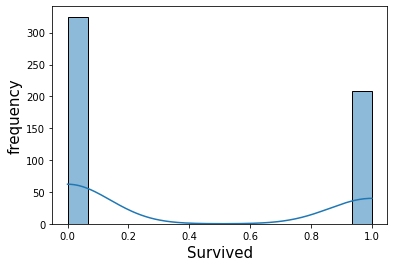

In [36]:
hystogramma(y, 'Survived')

### У - несбалансирован, поэтому воспользуемся метрикой ROC-AUC 

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

# отображение графиков AUC
def roc_auc_plot(y_train, y_train_predicted, y_val, y_val_predicted):
    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_val, y_val_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

In [38]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state = 2037)

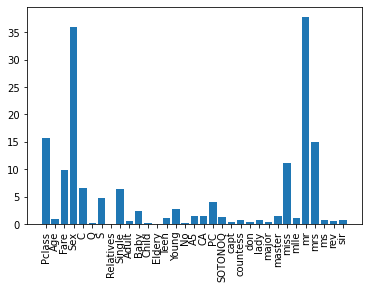

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif

#Оценим важность наших признаков алгоритмом SelectKBest.

selector = SelectKBest(f_classif, k=5)
selector.fit(x, y)

scores = -np.log10(selector.pvalues_)

plt.bar(range(len(num_cols)), scores)
plt.xticks(range(len(num_cols)), num_cols, rotation='vertical')
plt.show()

## Воспользуемся "Random forest" для предсказания

In [58]:
from sklearn.ensemble import RandomForestClassifier
alg_frst = RandomForestClassifier(random_state=42, 
                                  n_estimators=130, #кол-во деревьев
                                  criterion='gini', #Воспользуемся критерием Джини
                                  max_depth=10, #кол-во слоев в дереве
                                  oob_score=True,
                                  warm_start=False,
                                  n_jobs=-1,
                                  class_weight = "balanced_subsample",
                                  min_samples_split=8, 
                                  min_samples_leaf=3)

In [59]:
alg_frst.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=130, n_jobs=-1, oob_score=True,
                       random_state=42)

In [60]:
y_train_predicted = alg_frst.predict_proba(x_train)
y_test_predicted = alg_frst.predict_proba(x_test)

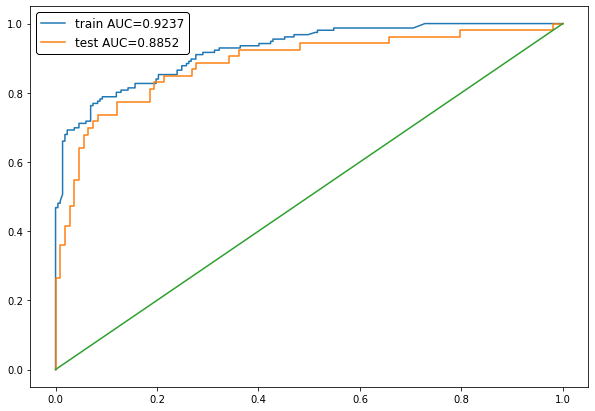

In [61]:
roc_auc_plot(y_train, y_train_predicted[:, 1], y_test, y_test_predicted[:, 1])

## Воспользуемся XGBooster

In [44]:
x_new = train_changed[num_cols]
y_new = train_changed['Survived']
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_new, y_new, train_size=0.7, random_state=2037)

In [45]:
from xgboost import XGBClassifier
XGB = XGBClassifier(seed=42, n_estimators=550, 
                    max_depth=4, min_child_weight=3, 
                    colsample_bytree=0.7, gamma=3, 
                    scale_pos_weight=0.85, reg_alpha=0.1, 
                    reg_lambda=1, learning_rate=0.1,
                    use_label_encoder=False, importance_type="weight",
                    predictor="gpu_predictor", objective='binary:logistic')

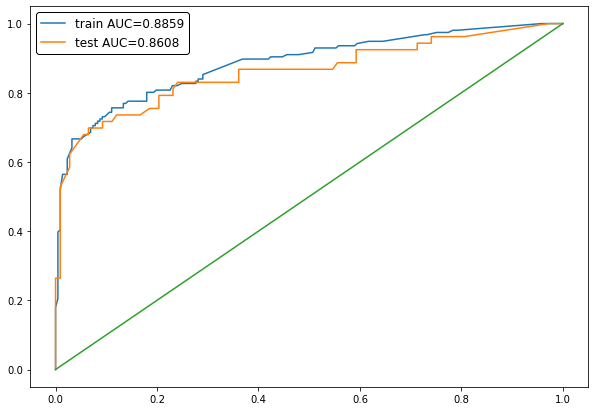

In [46]:
XGB.fit(x_train_new, y_train_new, eval_metric = 'logloss')
y_train_predicted = XGB.predict_proba(x_train_new)
y_test_predicted = XGB.predict_proba(x_test_new)
roc_auc_plot(y_train_new, y_train_predicted[:, 1], y_test_new, y_test_predicted[:, 1])

# Сделает предсказание для test и сохраним ответ

In [47]:
# сохраним колонку с id, для файла с ответом
result = test_changed[num_cols]
y_test_predicted_frst = alg_frst.predict_proba(result)[:, 1]

In [48]:
def create_submission(id_col, y_pred):
    submission = pd.DataFrame({
        'PassengerId': id_col,
        'Survived': y_pred
    })
    return submission

In [49]:
sub = create_submission(test["PassengerId"], y_test_predicted_frst)
sub

PassengerId  Survived
0            384  0.949785
1            882  0.159404
2            276  0.854574
3            648  0.378703
4            224  0.116068
..           ...       ...
352          115  0.645248
353          539  0.201931
354          656  0.295222
355           11  0.605202
356          308  0.919661

[357 rows x 2 columns]

In [50]:
#сохраним файл с ответом и загрузим его для на kaggle
#sub.to_csv("C:/Users/HP/Desktop/Studing spring/МаД/Laba_3/sub_4.csv", index=False)

In [51]:
# сохраним колонку с id, для файла с ответом
#result = test_changed[num_cols]
#y_test_predicted_xgb = XGB.predict_proba(result)[:, 1]

In [1]:
#sub.to_csv("sub.csv", index=False)